In [231]:
import networkx as nx
import numpy as np
from scipy import sparse
from prebuilt_code.ssf_masked.src_py.read_ccodes import *
import matplotlib.pyplot as plt
import itertools
import random

In [224]:
n_list = []
m_list = []
dv_list = []
dc_list = []
id_list = []
file_name_list = ["prebuilt_code/ssf_masked/ccode/24_20_5_6.code"]

code_list = read_ccode(file_name_list, n_list, m_list, dv_list, dc_list, id_list)
ccode = code_list[0]

In [225]:
check_nbhd = ccode.check_nbhd

H = np.zeros((ccode.m, ccode.n))
for i, check in enumerate(check_nbhd):
    for bit in check:
        H[i][bit] = 1
H = sparse.csc_matrix(H)

hx1 = sparse.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = sparse.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = sparse.csr_matrix(sparse.hstack([hx1, hx2]))

hz1 = sparse.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = sparse.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = sparse.csr_matrix(sparse.hstack([hz1, hz2]))

# qH = sparse.vstack([Hx, Hz])
qH = Hx

n = qH.shape[1]
m = qH.shape[0]

In [226]:
G = nx.Graph()
G.add_nodes_from(np.arange(n))

In [227]:
for i in range(m):
    checks = qH[i].indices
    for pair in itertools.combinations(checks, 2):
        G.add_edge(pair[0], pair[1])
len(G.edges)

24068

In [228]:
def percolation(G, p):
    """
    returns components if edges are removed from G with probability p
    (starting from empty graph adding edges with probability (1-p))
    """
    G_copy = G.copy()
    edges = list(G_copy.edges)
    for edge in edges:
        if (np.random.random() < p):
            G_copy.remove_edge(edge[0], edge[1])
            
    comps = sorted(nx.connected_components(G_copy), key=len, reverse=True)
    return comps[0] # return giant component

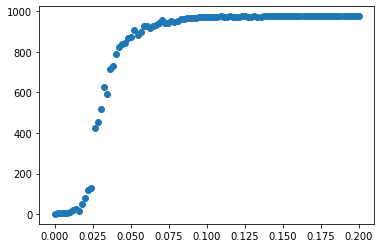

In [229]:
ps = np.linspace(0,0.2,100)
gcc_sizes = [len(percolation(G, 1-p)) for p in ps]
plt.scatter(ps, gcc_sizes)

In [230]:
G = nx.Graph()

vv_qubits = [(v1,v2,0) for v1 in range(ccode.n) for v2 in range(ccode.n)]
cc_qubits = [(c1,c2,1) for c1 in range(ccode.m) for c2 in range(ccode.m)]
G.add_nodes_from(vv_qubits + cc_qubits)

# only x gen
for qb in vv_qubits:
    for check in ccode.bit_nbhd[qb[1]]:
        for bit in ccode.check_nbhd[check]:
            G.add_edge(qb, (qb[0],bit,0))
        for bit in ccode.bit_nbhd[qb[0]]:
            G.add_edge(qb, (bit,check,1))

for qb in cc_qubits:
    for bit in ccode.check_nbhd[qb[0]]:
        for check in ccode.bit_nbhd[bit]:
            G.add_edge(qb, (check,qb[1],1))
        for check in ccode.check_nbhd[qb[1]]:
            G.add_edge(qb, (bit,check,0))

G.remove_edges_from(nx.selfloop_edges(G))
len(G.edges)


24068

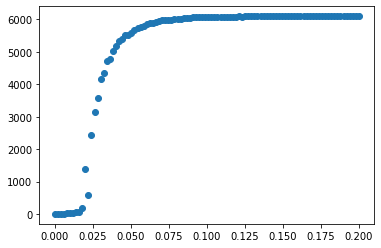

In [223]:
ps = np.linspace(0,0.2,100)
gcc_sizes = [len(percolation(G, 1-p)) for p in ps]
plt.scatter(ps, gcc_sizes)

In [261]:
def random_error(ccode, p):
    """
    Return a random iid error of proba 'p'
    """
    vv_xerror = [(v1,v2) for v1 in range(ccode.n) for v2 in range(ccode.n) if p > random.uniform(0,1)]
    cc_xerror = [(c1,c2) for c1 in range(ccode.m) for c2 in range(ccode.m) if p > random.uniform(0,1)]

    return (vv_xerror, cc_xerror)

p = 0.005
error = random_error(ccode, p)
vv_errors = [(vv[0],vv[1],0) for vv in error[0]]
cc_errors = [(cc[0],cc[1],1) for cc in error[1]]
H = G.subgraph(vv_errors + cc_errors)
comps = list(nx.connected_components(H))
print(comps)

[{(6, 14, 0), (16, 14, 1)}, {(6, 18, 1)}, {(10, 7, 1)}, {(15, 9, 0)}, {(9, 16, 1)}, {(22, 6, 0)}]


In [262]:
max(comps)

{(6, 14, 0), (16, 14, 1)}